# Fit PRDX1 koffs and kons

This notebook performs analyses described in the 

**Manuscript:**

Modelling the decamerisation cycle of PRDX1 and the inhibition-like effect on its peroxidase activity

**Authors:**

C. Barry, C. Pillay, J. Rohwer

**Purpose:**

Writes Barranco-Medina 2008 Fig. 1c PRDX1 injection parameters (filename: `ITC_PRDX1_inject_params.csv`)

Performs regression on ITC data digitized from Barranco-Medina et al. 2008 to fit the kon and koff of Prx decamer formation.

Writes fitted koff and kon (filename: `fitted_koff_kon_PRDX1_params.csv`)


**Requirements:**

Python libraries (see **Imports** below)

ITC Prx model (filename:`ITC_Prx_dim-dec.psc`)

ITC model parameters (filename: `ITC_data_PRDX1_processed.csv`)

##### Imports

In [1]:
import os
import math
import copy
import gc

import dill as pickle
import scipy as sp
import numpy as np
from lmfit import Minimizer, minimize, Parameters, Parameter, report_fit
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import auc
from scipy.interpolate import interp1d

import pysces
from identifiability import conf_interval


Matplotlib backend set to: "nbAgg"
Matplotlib interface loaded (pysces.plt.m)
Pitcon routines available
NLEQ2 routines available
SBML support available
You are using NumPy (1.23.5) with SciPy (1.9.3)
Assimulo CVode available
RateChar is available
Parallel scanner is available

PySCeS environment
******************
pysces.model_dir = /home/chris/Pysces/psc
pysces.output_dir = /home/chris/Pysces


***********************************************************************
* Welcome to PySCeS (1.0.3) - Python Simulator for Cellular Systems   *
*                http://pysces.sourceforge.net                        *
* Copyright(C) B.G. Olivier, J.M. Rohwer, J.-H.S. Hofmeyr, 2004-2022  *
* Triple-J Group for Molecular Cell Physiology                        *
* Stellenbosch University, ZA and VU University Amsterdam, NL         *
* PySCeS is distributed under the PySCeS (BSD style) licence, see     *
* LICENCE.txt (supplied with this release) for details                *
* Please cite PySCeS with

###### Save directories

In [2]:
prev_dir = os.path.split(os.getcwd())[0]

mod_dir = os.path.join(prev_dir,"models")
if not os.path.isdir(mod_dir): os.mkdir(mod_dir) # ensure dir exists

par_dir = os.path.join(prev_dir,"params")
if not os.path.isdir(par_dir): os.mkdir(par_dir) # ensure dir exists
    
fig_dir = os.path.join(os.getcwd(),"Figures")
if not os.path.isdir(fig_dir): os.mkdir(fig_dir) # ensure dir exists


###### Matplotlib stuff

In [3]:
%matplotlib inline

multiplier = 1
mpl_width = 4.5*multiplier
mpl_height = 3.5*multiplier
mpl_dpi = 600
mpl_xlabel_fontsize = "large"
mpl_ylabel_fontsize = "large"
mu = "\u03bc"

###### Fitting methods

In [4]:
# fitting_method = "nelder"
fitting_method = "leastsq"

## Barranco-Medina et al. 2008 PRDX1 

### data

In [5]:
df_PRDX1 = pd.read_csv(os.path.join(prev_dir,"ITC_data","ITC_data_PRDX1_processed.csv")).set_index('Time (sec)')

### Inject params

In [6]:
# Values from Barranco-Medina 2008
inj_enthalpy_PRDX1 = 156
inj_volume_PRDX1 = 1.6 # ul
inj_mon_PRDX1 = 102 # uM MONOMERS
inj_dim_est_PRDX1 = 0.8
inj_dec_est_PRDX1 = (inj_mon_PRDX1/2 - 0.8)/5
inj_interval_PRDX1 = 200 # sec


In [7]:
# Create df used to update models later
entry = {"Parameter": [ "injection_enthalpy",
                        "injection_volume",
                        "injection_Prx_mon",
                        "injection_dimer",
                        "injection_decamer",
                        "injection_interval",
                        "first_inject_ratio"],
         
       "Value":[inj_enthalpy_PRDX1,
                inj_volume_PRDX1,
                inj_mon_PRDX1,
                inj_dim_est_PRDX1, 
                inj_dec_est_PRDX1,
                inj_interval_PRDX1,
                1]}

df_ITC_PRDX1_inject_params = pd.DataFrame(entry)
df_ITC_PRDX1_inject_params.set_index("Parameter",inplace=True)
df_ITC_PRDX1_inject_params


,Value
Parameter,
injection_enthalpy,156.00
injection_volume,1.60
injection_Prx_mon,102.00
injection_dimer,0.80
injection_decamer,10.04
injection_interval,200.00
first_inject_ratio,1.00


In [8]:
# Write inject params to file
df_ITC_PRDX1_inject_params.to_csv(os.path.join(os.getcwd(),"ITC_PRDX1_inject_params.csv"),
                                  sep=',',
                                  encoding='utf-8')
df_ITC_PRDX1_inject_params.to_csv(os.path.join(par_dir, "ITC_PRDX1_inject_params.csv"),
                                  sep=',',
                                  encoding='utf-8')


## Fit functions

In [9]:
def load_ITC_model(inj_params):
    """
    Loads the ITC model and updates it with injection parameters.
    """
    # Load model
    mod_ITC_Prx_dim_dec = pysces.model("ITC_Prx_dim-dec.psc",dir = mod_dir)
    mod_ITC_Prx_dim_dec.mode_integrate_all_odes = True # As recommented by pysces
    mod_ITC_Prx_dim_dec.__settings__["cvode_access_solver"] = False
    mod_ITC_Prx_dim_dec.__settings__["cvode_return_event_timepoints"] = False
    mod_ITC_Prx_dim_dec.SetQuiet()

    # Note: exponent and Kd_app are set by the residual function
    
    # Set injection params
    for parameter in inj_params.index:
        value = inj_params.loc[parameter]["Value"]
        setattr(mod_ITC_Prx_dim_dec,parameter,value)
    
    return mod_ITC_Prx_dim_dec

def update_syringe_equis(mod_ITC_Prx_dim_dec):
    """
    Updates the ITC model with the equilibrium values of the dimers and decamers in the injection syringe.
    """
    # Load syringe model
    mod_Prx_dec_onestep = pysces.model("Prx_dim-dec.psc", dir = mod_dir)
    mod_Prx_dec_onestep.mode_integrate_all_odes = True # As recommented by pysces
    mod_Prx_dec_onestep.SetQuiet()

    # Set exponent and Kd_app equal to ITC model
    mod_Prx_dec_onestep.exponent = mod_ITC_Prx_dim_dec.exponent
    mod_Prx_dec_onestep.Kd_app = mod_ITC_Prx_dim_dec.Kd_app
    
    # Set injection concentrations
    mod_Prx_dec_onestep.dimers_init = mod_ITC_Prx_dim_dec.injection_dimer
    mod_Prx_dec_onestep.decamers_init =  mod_ITC_Prx_dim_dec.injection_decamer

    mod_Prx_dec_onestep.doState()
    print(f"dimers: {mod_Prx_dec_onestep.dimers_ss}")
    print(f"decamers: {mod_Prx_dec_onestep.decamers_ss}")

    # Populate ITC model syringe with equilibrium values
    mod_ITC_Prx_dim_dec.injection_dimer = mod_Prx_dec_onestep.dimers_ss
    mod_ITC_Prx_dim_dec.injection_decamer = mod_Prx_dec_onestep.decamers_ss
    
    return mod_ITC_Prx_dim_dec


def do_ITC_assay(mod, association_enthalpy, end = 3600):
    """
    Simulates and ITC trace and calculates the heat reading.
    Processes the heat reading data by correcting for baseline and normalizing to area under curve.
    """
    # Scan model
    mod.doSim(points = end+1,end = end)
    data, lbls = mod.data_sim.getAllSimData(lbls = True)
    
    # Calculate enthalpy
    lbls[0] = 'Time (sec)'
    df_sim = pd.DataFrame(data, columns = lbls)
    df_sim['Time (sec)'] = np.rint(df_sim['Time (sec)']).astype(int)
    df_sim = df_sim.set_index('Time (sec)')
    df_sim["Rate μcal/sec"] = (-df_sim["Disassociation"])*association_enthalpy*1/5*1/1000*60
    
    # Baseline correction
    df_sim = baseline_correction(df_sim, mod)
    
    df_sim.drop(0,inplace=True) 

    # Normalise to AUC
    df_sim = normalise_to_AUC(df_sim,mod)
    
    return df_sim

def baseline_correction(df_sim, mod):
    """
    Processes the heat reading data by correcting for baseline.
    """
    num_disso_injections = math.floor(df_sim["Rate μcal/sec"].index[-1]/mod.injection_interval)

    start = 1
    end = mod.injection_interval

    df_temp = pd.DataFrame(df_sim["Rate μcal/sec"].loc[start: end])

    next_baseline = df_temp[-10:-5]

    x2 = next_baseline.index.values.mean()
    y2 = next_baseline["Rate μcal/sec"].mean()

    x1 = 0.0
    y1 = next_baseline["Rate μcal/sec"].mean()

    baseline_interp = interp1d([x1,x2], [y1,y2],fill_value="extrapolate")(df_temp.index)

    current_baseline = next_baseline
    
    df_temp["Rate μcal/sec"] = df_temp["Rate μcal/sec"] - baseline_interp

    df_sim_baseline = pd.DataFrame(df_temp)

    count = 1
    while count < num_disso_injections:
        start = count*mod.injection_interval+1
        end = count*mod.injection_interval + mod.injection_interval

        df_temp = pd.DataFrame(df_sim["Rate μcal/sec"].loc[start: end])

        next_baseline = df_temp[-10:-5]

        x2 = next_baseline.index.values.mean()
        y2 = next_baseline["Rate μcal/sec"].mean()

        x1 = current_baseline.index.values.mean()
        y1 = current_baseline["Rate μcal/sec"].mean()

        baseline_interp = interp1d([x1,x2], [y1,y2],fill_value="extrapolate")(df_temp.index)

        df_temp["Rate μcal/sec"] = df_temp["Rate μcal/sec"] - baseline_interp

        current_baseline = next_baseline

        df_sim_baseline = pd.concat([df_sim_baseline,df_temp])

        count += 1

    df_sim["Rate μcal/sec no baseline corr."] = df_sim["Rate μcal/sec"].copy(deep=True)
    df_sim["Rate μcal/sec"] = df_sim_baseline["Rate μcal/sec"].copy(deep=True)

    return df_sim

def normalise_to_AUC(df_sim,mod):
    """
    Processes the heat reading data by normalizing for area under the curve.
    """
    num_disso_injections = math.floor(df_sim["Rate μcal/sec"].index[-1]/mod.injection_interval)

    start = 0
    end = mod.injection_interval
    df_temp = pd.DataFrame(df_sim["Rate μcal/sec"].loc[start: end])

    area = np.abs(np.trapz(df_temp.values.flatten(),df_temp.index))
    print(area)
    df_sim_AUCnorm = df_temp/area

    count = 1
    while count < num_disso_injections:
        start = count*mod.injection_interval
        end = start + mod.injection_interval
        df_temp = pd.DataFrame(df_sim["Rate μcal/sec"].loc[start: end])
        area = np.abs(np.trapz(df_temp.values.flatten(),df_temp.index))
        print(f"Area: {area}")
        df_temp = df_temp/area
        df_sim_AUCnorm = pd.concat([df_sim_AUCnorm,df_temp])
        count += 1

    df_sim_AUCnorm = df_sim_AUCnorm.reset_index().drop_duplicates(subset='Time (sec)', 
                                                                  keep='last').set_index('Time (sec)').sort_index()

    df_sim["Rate μcal/sec baseline no AUC"] = df_sim["Rate μcal/sec"].copy(deep=True)
    df_sim["Rate μcal/sec"] = df_sim_AUCnorm
    
    return df_sim

def fit_koff_kon_res(params, mod, enthalpy, df_data):
    """
    This is where the residuals which will be minimized are generated.
    Must contain the following:
    Update model params
    Scan model
    Calculate and return residuals
    """
    
    # Update model
    mod.koff = params['koff'].value
    mod.Kd_app = params['Kd_app'].value
    mod.kon = mod.koff/mod.Kd_app

    # Store kon in params
    params['kon'].value = mod.kon
    
    # Update initial dimers and decamers per syringe equilibrium
    update_syringe_equis(mod)
    
    # Scan model
    df_sim = do_ITC_assay(mod, enthalpy)
    
    # Calculate residuals
    residuals = (df_data["Rate μcal/sec"].values - df_sim.loc[df_data.index]["Rate μcal/sec"].values)**2
    
    return residuals


## Fit koff kon (figures 4a and 4b)

Fit the koff (and also kon) using the Barranco-Medina et al. 2008 PRDX1 data and ITC model.

In [10]:
# Kd_app and exponent
exponent = 5
Kd_app_vil = 1.1 # Villar

In [11]:
# Load model
mod_ITC_Prx_dim_dec = load_ITC_model(df_ITC_PRDX1_inject_params)
Kd_app = 1.1 # Villar
PRDX1_enthalpy = mod_ITC_Prx_dim_dec.injection_enthalpy

setattr(mod_ITC_Prx_dim_dec,"exponent",exponent)
setattr(mod_ITC_Prx_dim_dec,"Kd_app",Kd_app_vil)
    
# Store injection enthalpy
PRDX1_enthalpy = mod_ITC_Prx_dim_dec.injection_enthalpy

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/ITC_Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/ITC_Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Kd_app" has been initialised but does not occur in a rate equation
Info: "injection_volume" has been initialised but does not occur in a rate equation
Info: "injection_dimer" has been initialised but does not occur in a rate equation
Info: "injection_decamer" has been initialised but does not occur in a rate equation
Info: "injection_interval" has been initialised but does not occur in a rate equation
Info: "first_inject_ratio" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conserv

In [12]:
# Set up lmfit parameter library object with each parameter to be fitted
param_lib = Parameters()
param_lib.add('koff',value=100.0,min=1e-12)
param_lib.add('kon',value=100.0,min=1e-12,vary=False)
param_lib.add('Kd_app', value = Kd_app_vil,vary=False, min = 1e-12)

# Perform fit
fit_koff_kon = minimize(fit_koff_kon_res, 
                         param_lib, 
                         method=fitting_method,
                         args=(mod_ITC_Prx_dim_dec,
                               mod_ITC_Prx_dim_dec.injection_enthalpy,
                               df_PRDX1),
                         epsfcn=0.0001)

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 

28.475576722405144
Area: 28.19976120889725
Area: 27.384399904698704
Area: 25.776404236425286
Area: 23.414766688704827
Area: 20.656295790876072
Area: 17.92142901198435
Area: 15.47381622870134
Area: 13.40017838765062
Area: 11.685094035397222
Area: 10.275584058802696
Area: 9.113874936618405
Area: 8.149378645401754
Area: 7.3412620016135754
Area: 6.657607926172411
Area: 6.073762926505026
Area: 5.570685731924846
Area: 5.133590148831272
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcul

28.465228880907812
Area: 28.18940091096043
Area: 27.374035154566666
Area: 25.76604609197798
Area: 23.404440715473182
Area: 20.646032339298444
Area: 17.91125190070154
Area: 15.463742262773838
Area: 13.390218763420792
Area: 11.675255601565867
Area: 10.265870623340176
Area: 9.104289348383869
Area: 8.139920435310584
Area: 7.331929409681843
Area: 6.648401086755788
Area: 6.064679961274808
Area: 5.561724941884329
Area: 5.1247501056462665
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcu

28.42694825379195
Area: 28.151116888145484
Area: 27.335744764533167
Area: 25.727795918877185
Area: 23.366322502618363
Area: 20.608150992588335
Area: 17.873694282662914
Area: 15.426570356132514
Area: 13.353473980447292
Area: 11.638964151969803
Area: 10.230046346592099
Area: 9.068937435034565
Area: 8.105043653927078
Area: 7.297526130425577
Area: 6.614467349105364
Area: 6.031211156210571
Area: 5.528712633685135
Area: 5.092188788371442
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calc

28.446464658158543
Area: 28.1706296236216
Area: 27.355257517203608
Area: 25.747285999684703
Area: 23.385742869782703
Area: 20.62744954118869
Area: 17.89282696835854
Area: 15.445505600022967
Area: 13.372190633663354
Area: 11.65744868752079
Area: 10.248291734318533
Area: 9.086940540827445
Area: 8.122803514140488
Area: 7.315044604899912
Area: 6.631745501822333
Area: 6.048251295253717
Area: 5.545518699487048
Area: 5.108764245481952
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculat


event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is evaluating at 601.0
event injection_vol is assigning at 601.0 (delay=0.0)

event injection_prot is evaluating at 801.0
event injection_prot is assigning at 801.0 (delay=0.0)

event injection_vol is evaluating at 801.0
event injection_vol is assigning at 801.0 (delay=0.0)

event injection_prot is evaluating at 1001.0
event injection_prot is assigning at 1001.0 (delay=0.0)

event injection_vol is evaluating at 1001.0
event injection_vol is assigning at 1001.0 (delay=0.0)

event injection_prot is evaluating at 1201.0
event injection_prot is assigning at 1201.0 (delay=0.0)

event injection_vol is evaluating at 1201.0
event injection_vol is assigning at 1201.0 (delay=0.0)

e

28.451924860138252
Area: 28.176090927092286
Area: 27.360721461811067
Area: 25.75274320946773
Area: 23.39118221214039
Area: 20.632854734450447
Area: 17.898186062051423
Area: 15.450809759488617
Area: 13.377433933781312
Area: 11.662627395292274
Area: 10.253403892985965
Area: 9.09198584091971
Area: 8.127781316103011
Area: 7.319954286831686
Area: 6.636588299214795
Area: 6.053027943539944
Area: 5.55023027675758
Area: 5.113411528056462
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calcula

Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 
dimers: 1.5811914353803906
decamers: 9.883761712923922

event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_


event injection_prot is evaluating at 1801.0
event injection_prot is assigning at 1801.0 (delay=0.0)

event injection_vol is evaluating at 1801.0
event injection_vol is assigning at 1801.0 (delay=0.0)

event injection_prot is evaluating at 2001.0
event injection_prot is assigning at 2001.0 (delay=0.0)

event injection_vol is evaluating at 2001.0
event injection_vol is assigning at 2001.0 (delay=0.0)

event injection_prot is evaluating at 2201.0
event injection_prot is assigning at 2201.0 (delay=0.0)

event injection_vol is evaluating at 2201.0
event injection_vol is assigning at 2201.0 (delay=0.0)

event injection_prot is evaluating at 2401.0
event injection_prot is assigning at 2401.0 (delay=0.0)

event injection_vol is evaluating at 2401.0
event injection_vol is assigning at 2401.0 (delay=0.0)

event injection_prot is evaluating at 2601.0
event injection_prot is assigning at 2601.0 (delay=0.0)

event injection_vol is evaluating at 2601.0
event injection_vol is assigning at 2601.0 (d

In [13]:
# Display fit report
fit_koff_kon 

In [14]:
# Simulate ITC with fitted parameters
df_sim = do_ITC_assay(mod_ITC_Prx_dim_dec,PRDX1_enthalpy)
residuals = (df_PRDX1["Rate μcal/sec"].values - df_sim.loc[df_PRDX1.index]["Rate μcal/sec"].values)**2


event first_injection_prot is evaluating at 3.4322590648825023e-05
event first_injection_prot is assigning at 3.4322590648825023e-05 (delay=0.0)

event first_injection_vol is evaluating at 3.4322590648825023e-05
event first_injection_vol is assigning at 3.4322590648825023e-05 (delay=0.0)

event injection_prot is evaluating at 1.0
event injection_prot is assigning at 1.0 (delay=0.0)

event injection_vol is evaluating at 1.0
event injection_vol is assigning at 1.0 (delay=0.0)

event injection_prot is evaluating at 201.0
event injection_prot is assigning at 201.0 (delay=0.0)

event injection_vol is evaluating at 201.0
event injection_vol is assigning at 201.0 (delay=0.0)

event injection_prot is evaluating at 401.0
event injection_prot is assigning at 401.0 (delay=0.0)

event injection_vol is evaluating at 401.0
event injection_vol is assigning at 401.0 (delay=0.0)

event injection_prot is evaluating at 601.0
event injection_prot is assigning at 601.0 (delay=0.0)

event injection_vol is 

/tmp/ipykernel_8730/84095838.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


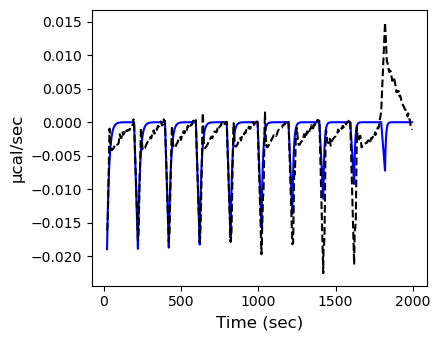

In [15]:
# Plot all fitted peaks
rows = 1
cols = 1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_sim.loc[df_PRDX1.index].index, 
           df_sim.loc[df_PRDX1.index]["Rate μcal/sec"],
           "b-", 
           label = "mod sim")
axarr.plot(df_PRDX1.index, df_PRDX1["Rate μcal/sec"],"k--", label = "exp data")

axarr.set_xlabel(f'Time (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,f"fit_koff_ITC_heat_vs_time.pdf"),dpi= mpl_dpi)

/tmp/ipykernel_8730/3937970084.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


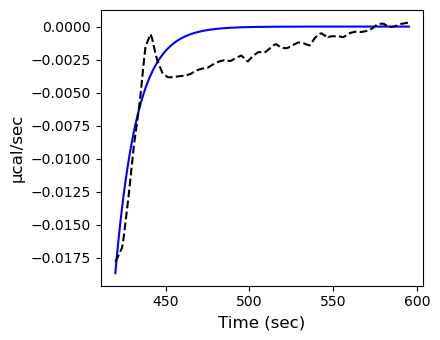

In [16]:
# Plot single peak
inject_num = 2
injection_interval = 200

start = inject_num*injection_interval
end = start + injection_interval

rows = 1
cols = 1

f,axarr = plt.subplots(rows,cols)
f.set_size_inches(w=mpl_width*cols, h=mpl_height*rows)

axarr.plot(df_sim.loc[df_PRDX1.index].loc[start: end].index, 
           df_sim.loc[df_PRDX1.index].loc[start: end]["Rate μcal/sec"],
           "b-", 
           label = "mod sim")
axarr.plot(df_PRDX1.loc[start: end].index, 
           df_PRDX1.loc[start: end]["Rate μcal/sec"],
           "k--", 
           label = "exp data")

axarr.set_xlabel(f'Time (sec)',fontsize = mpl_xlabel_fontsize)
axarr.set_ylabel(f'{mu}cal/sec',fontsize = mpl_ylabel_fontsize)

f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,f"fit_koff_ITC_heat_peak_vs_time.pdf"),dpi= mpl_dpi)
          

## Write fitted koff and kon to file

In [17]:
# Set up df
data = {"Parameter": ["koff",
                     "kon",
                     "Kd_app"],
        "Value":[fit_koff_kon.params["koff"].value,
                fit_koff_kon.params["kon"].value,
                fit_koff_kon.params["Kd_app"].value]}
df_fitted_koff_kon_params = pd.DataFrame(data)
df_fitted_koff_kon_params.set_index("Parameter",inplace=True)
df_fitted_koff_kon_params

,Value
Parameter,
koff,102.306982
kon,93.006348
Kd_app,1.100000


In [18]:
# Write to file
df_fitted_koff_kon_params.to_csv(os.path.join(os.getcwd(),"fitted_koff_kon_PRDX1_params.csv"),
                                 sep=',',
                                 encoding='utf-8')
df_fitted_koff_kon_params.to_csv(os.path.join(par_dir,"fitted_koff_kon_PRDX1_params.csv"),
                                 sep=',',
                                 encoding='utf-8')
